In [1]:
# Import Dependencies

import pandas as pd
import numpy as np
from fbprophet import Prophet
import requests
from pprint import pprint
from datetime import datetime, timedelta
from bs4 import BeautifulSoup as bs
from sqlalchemy import create_engine
import psycopg2
from config import server, database, port, username, password, av_api_key, nyt_api_key


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [2]:
# Server Details
conn = f"postgres://{username}:{password}@{server}:{port}/{database}"

In [3]:
# Read Bitcoin daily data from Alpha Vantage API

url = "https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol=BTC&market=CAD&apikey={av_api_key}"

data = requests.get(url).json()
bc_data = data["Time Series (Digital Currency Daily)"]

In [4]:
# Loop through json response API data and transform into lists in python to create pandas dataframe

date = []
open_CAD = []
open_USD = []
high_CAD = []
high_USD = []
low_CAD = []
low_USD = []
close_CAD = []
close_USD = []
volume = []

date = list(bc_data.keys())

for d in date:
  value = bc_data[d]
  close_CAD.append(value['4a. close (CAD)'])
  close_USD.append(value['4b. close (USD)'])
  volume.append(value['5. volume'])
  open_CAD.append(value['1a. open (CAD)'])
  open_USD.append(value['1b. open (USD)'])
  high_CAD.append(value['2a. high (CAD)'])
  high_USD.append(value['2b. high (USD)'])
  low_CAD.append(value['3a. low (CAD)'])
  low_USD.append(value['3b. low (USD)'])

In [5]:
# Create Pandas dataframe

df = pd.DataFrame({"Date": date, "Open_USD": open_USD, "High_USD": high_USD,  "Low_USD": low_USD,  "Close_USD":close_USD, "Volume": volume})
df.head()

,Date,Open_USD,High_USD,Low_USD,Close_USD,Volume
0,2021-03-24,54342.80000000,54669.35000000,53756.91000000,53926.93000000,1830.96616000
1,2021-03-23,54083.25000000,55830.90000000,53000.00000000,54340.89000000,59789.36542700
2,2021-03-22,57351.56000000,58430.73000000,53650.00000000,54083.25000000,62581.62616900
3,2021-03-21,58100.02000000,58589.10000000,55450.11000000,57351.56000000,48564.47027400
4,2021-03-20,58030.01000000,59880.00000000,57820.17000000,58102.28000000,44476.94177600


In [6]:
engine = create_engine(conn, echo=False)

In [7]:
df.to_sql("coin_price", con=engine, if_exists = 'replace', index=False, method='multi')

with engine.connect() as con:
    con.execute('ALTER TABLE "coin_price" ADD PRIMARY KEY ("Date");')

In [8]:
# Coin Market Cap URL of page to be scraped for Market Cap data

cmc_url = 'https://coinmarketcap.com/'

# Retrieve page with the requests module

response = requests.get(cmc_url)

# Create BeautifulSoup object; parse with 'html.parser'

soup = bs(response.text, 'html.parser')

In [9]:
#Scrape url for the data

results = soup.find_all('div', class_='sc-33i2yg-0 dOnegn')

for r in results:
  header = r.find_all('span', class_="sc-12ja2s9-0 eALoKW")
   
  title =[]
  value =[]
  for values in header:
    data = (values.text.split(":"))
    title.append(data[0])

    if data[0] == "Dominance":
      value.append(data[2][1:5])
    else:
      value.append(data[1][2:])

In [10]:
# create data table in pandas and clean up data

market_cap_df = pd.DataFrame({"Title": title, "Value": value})
market_cap_df = market_cap_df.drop(index=5)
market_cap_df = market_cap_df.transpose()
columns = market_cap_df.iloc[0].values
market_cap_df.columns = columns
market_cap_df.drop('Title', axis=0, inplace = True)
market_cap_df.reset_index(inplace=True)
market_cap_df = market_cap_df.drop(columns='index')
market_cap_df = market_cap_df.rename(columns={"Dominance": "BTC_Dominance", "Market Cap": "Total_Market_Cap", "24h Vol": "24h_Volume"})
market_cap_df['Total_Market_Cap'] = market_cap_df['Total_Market_Cap'].str.replace("$","")
market_cap_df['24h_Volume'] = market_cap_df['24h_Volume'].str.replace("$","")
market_cap_df = market_cap_df.replace(',','', regex=True)
market_cap_df['BTC_Market_Cap_T'] = market_cap_df['Total_Market_Cap'].astype(float)*(market_cap_df['BTC_Dominance'].astype(float)/100)
market_cap_df['BTC_Market_Cap_T']= round((market_cap_df['BTC_Market_Cap_T']/1000000000000),2)
market_cap_df

,Cryptocurrencies,Markets,Total_Market_Cap,24h_Volume,BTC_Dominance,BTC_Market_Cap_T
0,8936,36929,1775034067758,129784574159,60.0,1.07


In [11]:
engine = create_engine(conn, echo=False)

In [12]:
market_cap_df.to_sql("market_cap", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "market_cap" ADD PRIMARY KEY ("Cryptocurrencies");')

In [13]:
#Use the NY Times API to pull recent Bitcoin news

url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?"

# Store a search term
query = "Bitcoin"

# Search for articles published between a begin date (90 days ago) and end date (current date)

end_date = datetime.today()
begin_date = end_date - timedelta(90)

end_date = end_date.strftime('%Y%m%d')
begin_date = begin_date.strftime('%Y%m%d')


query_url = f"{url}api-key={nyt_api_key}&q={query}&begin_date={begin_date}&end_date={end_date}"

# Retrieve articles
articles = requests.get(query_url).json()

In [14]:
# Transform API response into pandas df

headline = []
date = []
paragraph = []

articles_list = articles["response"]["docs"]

for article in articles_list:
  headline.append(article["headline"]["main"])
  date.append(article["pub_date"])
  paragraph.append(article["lead_paragraph"])

news_df = pd.DataFrame({"Date": date, "Headline": headline, "Paragraph": paragraph})
news_df['Date'] = pd.to_datetime(news_df['Date'], infer_datetime_format=True)
news_df['Date'] = news_df['Date'].dt.strftime('%Y-%m-%d')
news_df = news_df.sort_values(by='Date', ascending=False)
news_df.head()

,Date,Headline,Paragraph
1,2021-03-24,"Tesla will accept Bitcoin as payment, Elon Mus...","Elon Musk, the chief executive of Tesla who re..."
4,2021-03-24,Coinbase Users Say Crypto Start-Up Ignored The...,Michael Pierre was sitting in his Brooklyn apa...
0,2021-03-23,Miami Wants to Be the Hub for Bitcoin,Mayor Francis Suarez of Miami is selling his c...
5,2021-03-16,Twitter Hacker Pleads Guilty in Florida Court,The young hacker accused of being the mastermi...
6,2021-03-13,"From Crypto Art to Trading Cards, Investment M...",To hear more audio stories from publishers lik...


In [15]:
engine = create_engine(conn, echo=False)

In [16]:
news_df.to_sql("btc_news", con=engine, if_exists = 'replace', index=False)

with engine.connect() as con:
    con.execute('ALTER TABLE "btc_news" ADD PRIMARY KEY ("Headline");')

**Facebook Prophet** Machine Learning

In [17]:
# Facebook Prophet Model Setup

fb_df = df[["Date", "Close_USD"]]
fb_df = fb_df.rename(columns={"Date": "ds", "Close_USD": "y"})
#fb_df.head()

In [18]:
# Create fbProphet model and fit model 
model = Prophet(daily_seasonality=True)
model.fit(fb_df)

In [19]:
# Model 30 days in the future

future_df = model.make_future_dataframe(periods=30)

In [20]:
#Make predictions

predictions = model.predict(future_df)
predictions.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1025,2021-04-19,68131.504892,62790.436154,66850.955426,67578.176946,68607.427214,-3325.878682,-3325.878682,-3325.878682,-6397.547419,-6397.547419,-6397.547419,-9.822581,-9.822581,-9.822581,3081.491318,3081.491318,3081.491318,0.0,0.0,0.0,64805.626211
1026,2021-04-20,68370.166384,63256.920506,66965.880387,67797.785341,68888.091186,-3259.249887,-3259.249887,-3259.249887,-6397.547419,-6397.547419,-6397.547419,-51.384548,-51.384548,-51.384548,3189.682079,3189.682079,3189.682079,0.0,0.0,0.0,65110.916497
1027,2021-04-21,68608.827876,63433.368401,67452.925863,67993.944263,69165.892140,-3058.089994,-3058.089994,-3058.089994,-6397.547419,-6397.547419,-6397.547419,33.448499,33.448499,33.448499,3306.008927,3306.008927,3306.008927,0.0,0.0,0.0,65550.737882
1028,2021-04-22,68847.489368,63809.111783,67954.954610,68197.220548,69435.772514,-2981.448298,-2981.448298,-2981.448298,-6397.547419,-6397.547419,-6397.547419,-13.706706,-13.706706,-13.706706,3429.805827,3429.805827,3429.805827,0.0,0.0,0.0,65866.041071
1029,2021-04-23,69086.150860,64279.931593,68125.753237,68413.197697,69705.837176,-2812.438507,-2812.438507,-2812.438507,-6397.547419,-6397.547419,-6397.547419,24.851657,24.851657,24.851657,3560.257255,3560.257255,3560.257255,0.0,0.0,0.0,66273.712353


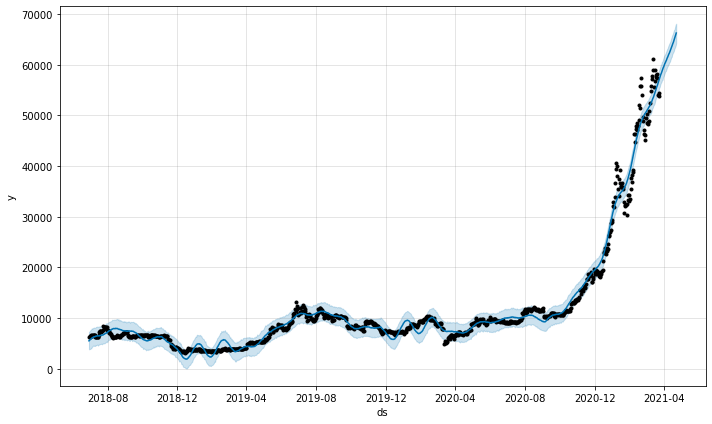

In [21]:
# Plot Predictions
model.plot(predictions).savefig('modelpredictions.png')


In [22]:
predictions_df = predictions.drop(columns=['yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'])


predictions_df['day'] = predictions_df['ds'].dt.day_name()
predictions_df['ds'] = predictions_df['ds'].dt.strftime('%Y-%m-%d')
predictions_df = predictions_df.rename(columns={"ds": "date", "trend": "BTC_price_USD"})
predictions_df.tail()

,date,BTC_price_USD,day
1025,2021-04-19,68131.504892,Monday
1026,2021-04-20,68370.166384,Tuesday
1027,2021-04-21,68608.827876,Wednesday
1028,2021-04-22,68847.489368,Thursday
1029,2021-04-23,69086.150860,Friday


In [23]:
engine = create_engine(conn, echo=False)

In [24]:
predictions_df.to_sql("fb_predictions", con=engine, if_exists = 'replace', index=False, method='multi')

with engine.connect() as con:
    con.execute('ALTER TABLE "fb_predictions" ADD PRIMARY KEY ("BTC_price_USD");')

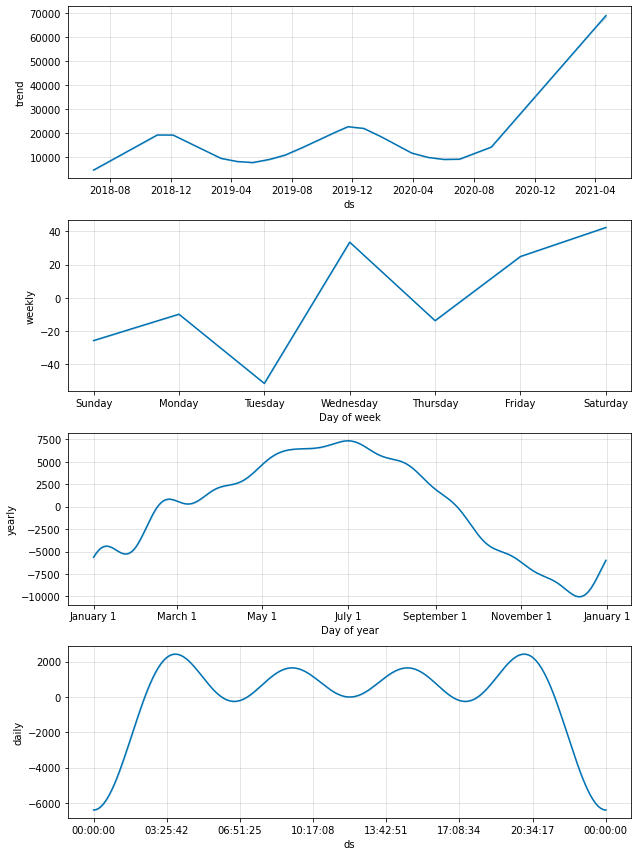

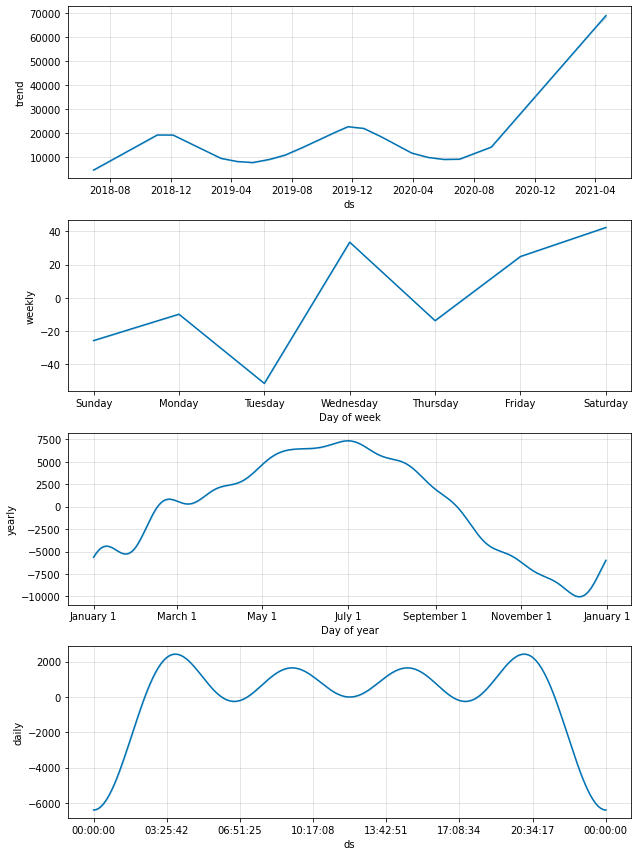

In [25]:
# Plot model components

model.plot_components(predictions)